In [53]:
from polaritonic import polaritonic
import numpy as np
#from matplotlib import pyplot as plt
#import matplotlib.animation as animation
import time
import sys

### dummi initial position and velocity values
ri_init = -0.66156
vi_init = 3.3375e-5

### Number of repeates
N_repeats = 1 #int(sys.argv[1])
### photonic mode dissipation rate in meV, gamma
gamp = 0. #float(sys.argv[2]) 
#gamp = 0.1
### convert to a.u.
gam_diss_np = gamp * 1e-3 / 27.211

### photonic mode energy in eV
omp = 2.45 #float(sys.argv[3])
#omp = 2.45
### convert to a.u.
omc = omp/27.211
### coupling strength in eV
gp = 0.02 #float(sys.argv[4])
#gp = 0.02
gc = gp/27.211

au_to_ps = 2.4188e-17 * 1e12

### get prefix for data file names
prefix = "test" #sys.argv[5]
#prefix = "test"
### filename to write nuclear trajectory to
nuc_traj_fn = "Data/" + prefix + '_nuc_traj.txt'
### filename to wrote PES to
pes_fn = "Data/" + prefix + '_pes.txt'
cpes_fn = "Data/" + prefix + '_complex_pes.txt'
### filename to write electronic/polaritonic dynamics to
ed_fn = "Data/" + prefix + '_electronic.txt'
### filename to write photonic contributions of each state to
pc_fn = "Data/" + prefix + '_photon_contribution.txt'
cpc_fn = "Data/" + prefix + '_complex_photon_contribution.txt'
### hellman-Feynman file 
hf_fn = "Data/" + prefix + "_hf.txt"
chf_fn = "Data/" + prefix + "_chf.txt"
### Number of updates!
N_time = 40#00000

### N_thresh controls when you start taking the average position
N_thresh = int( N_time / 4)



options = {
        'Number_of_Photons': 1,
        'Complex_Frequency': True,
        'Photon_Energys': [omc],
        'Coupling_Strengths': [gc], 
        'Photon_Lifetimes': [gam_diss_np],
        'Initial_Position': ri_init,
        'Initial_Velocity': vi_init,
        'Mass': 1009883,
        ### temperature in a.u.
        'Temperature': 0.00095,
        ### friction in a.u.
        'Friction': 0.000011,
        ### specify initial state as a human would, not a computer...
        ### i.e. 1 is the ground state... it will be shifted down by -1 so
        ### that it makes sense to the python index convention
        'Initial_Local_State': 3
        
        }

### instantiate
polt = polaritonic(options)


### Write potential energy surface!
polt.Write_PES(pes_fn, pc_fn)
polt.Write_CPES(cpes_fn, cpc_fn)

polt.Write_Forces(hf_fn)
polt.Write_CForces(chf_fn)

1

Even if $\gamma = 0$, the fact that we use complex $\omega$ type leads to some discrepencies in quantities, like the derivative coupling vectors.  See below for the plot of $d_{3,2}$ computed with $\omega = 2.45 eV$
and $\omega = 2.45 + 0i eV$.

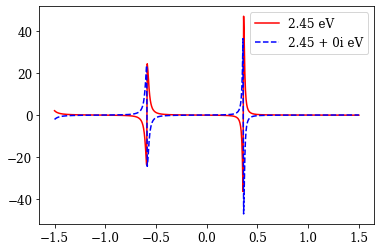

In [62]:
from matplotlib import pyplot as plt
from matplotlib import animation
from matplotlib import cm
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 12
fp1 = "Data/test_hf.txt"
fp2 = "Data/test_chf.txt"
one = np.loadtxt(fp1)
two = np.loadtxt(fp2,dtype=complex)

### plot the derivative coupling ve
plt.plot(one[:,0], one[:,3], 'red', label = "2.45 eV")
plt.plot(two[:,0], np.real(two[:,3]), 'b--', label = "2.45 + 0i eV")
plt.legend()
plt.show()



The problem seems to be that some (though not all) eigenvectors of $H_{Tot}$ differ by a sign when using complex $\omega$. See below for a comparison between ${\bf c}_2$ at $R = -1.5 a.u.$

In [55]:
polt.R = -1.5
polt.H_e()
polt.Hc_total = np.copy(polt.H_electronic + polt.Hc_photonic + polt.H_interaction)
polt.H_total = np.copy(polt.H_electronic + polt.H_photonic + polt.H_interaction)

polt.Transform_L_to_P()
polt.cTransform_L_to_P()

print(polt.ctransformation_vecs_L_to_P[:,1])
print(polt.transformation_vecs_L_to_P[:,1])

[-0.        -0.j  0.98369585+0.j -0.17984014-0.j -0.        -0.j]
[ 0.         -0.98369585  0.17984014  0.        ]


The question is does this impact the dynamics?  Let's investigate how 
\begin{equation}
[{\bf d},{\bf D}]
\end{equation}
differs using the derivative coupling vector and density matrix corresponding to real $\omega$ as compared
to complex $\omega$.

In [56]:
Dc_33 = np.outer(polt.ctransformation_vecs_L_to_P[:,2], 
                             np.conj(polt.ctransformation_vecs_L_to_P[:,2]))

Dc_22 = np.outer(polt.ctransformation_vecs_L_to_P[:,1], 
                             np.conj(polt.ctransformation_vecs_L_to_P[:,1]))

D_33 = np.outer(polt.transformation_vecs_L_to_P[:,2], 
                             np.conj(polt.transformation_vecs_L_to_P[:,2]))

D_22 = np.outer(polt.transformation_vecs_L_to_P[:,1], 
                             np.conj(polt.transformation_vecs_L_to_P[:,1]))


sup = np.sqrt(1/2.) * polt.transformation_vecs_L_to_P[:,1] + np.sqrt(1j/2.) * polt.transformation_vecs_L_to_P[:,2]

D_sup = np.outer(sup, np.conj(sup))


### Real Hamiltonians first
polt.R = polt.R + polt.dr
polt.H_e()
polt.H_total = np.copy(polt.H_electronic + polt.H_photonic + polt.H_interaction)
Hf = np.copy(polt.H_total)
### backward step
polt.R = polt.R - 2*polt.dr
polt.H_e()
polt.H_total = np.copy(polt.H_electronic + polt.H_photonic + polt.H_interaction)
Hb = np.copy(polt.H_total)
### derivative
Hprime = np.copy((Hf-Hb)/(2*polt.dr))
polt.Derivative_Coupling(Hprime)

### return to forward step
polt.R = polt.R + 2*polt.dr
polt.H_e()
polt.Hc_total = np.copy(polt.H_electronic + polt.Hc_photonic + polt.H_interaction)
Hf = np.copy(polt.Hc_total)
### backward step
polt.R = polt.R - 2*polt.dr
polt.H_e()
polt.Hc_total = np.copy(polt.H_electronic + polt.Hc_photonic + polt.H_interaction)
Hb = np.copy(polt.Hc_total)
### derivative
Hcprime = np.copy((Hf-Hb)/(2*polt.dr))
polt.cDerivative_Coupling(Hcprime)

A = np.dot(polt.dc, D_33)
B = np.dot(D_33, polt.dc)
C = np.dot(polt.cdc, Dc_33)
D = np.dot(Dc_33, polt.cdc)

print("[dc, D]")
print(A-B)
print("[cdc,Dc]")
print(C-D)
DA = D_33 - polt.V * (A-B) * polt.dt
DD = Dc_33 - polt.V *(C-D) * polt.dt


print("Real")
print(DA)
print("Complex")
print(DD)
#print("Real dc")
#print(polt.dc)
#print("complex dc")
#print(polt.cdc)

[dc, D]
[[ 0.          0.          0.          0.        ]
 [ 0.         -0.74534222 -1.97031738  0.        ]
 [ 0.         -1.97031738  0.74534222  0.        ]
 [ 0.          0.          0.          0.        ]]
[cdc,Dc]
[[ 0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.74534222+0.j  1.97031738+0.j  0.        +0.j]
 [ 0.        +0.j  1.97031738+0.j -0.74534222+0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j]]
Real
[[0.         0.         0.         0.        ]
 [0.         0.03234546 0.17691589 0.        ]
 [0.         0.17691589 0.96765454 0.        ]
 [0.         0.         0.         0.        ]]
Complex
[[ 0.        +0.j  0.        -0.j -0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.03233949+0.j  0.1769001 -0.j  0.        +0.j]
 [-0.        +0.j  0.1769001 +0.j  0.96766051+0.j -0.        +0.j]
 [ 0.        +0.j  0.        -0.j -0.        +0.j  0.        +0.j]]


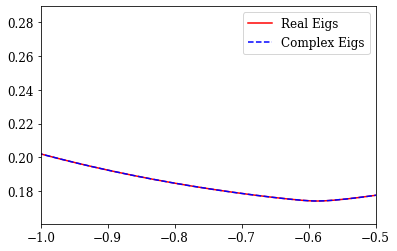

'\nfig, ax = plt.subplots()\ncm = plt.cm.get_cmap(\'rainbow\')\nim = ax.scatter(cpes[:,0], 27.211*np.abs(cpes[:,1]), c=cpc[:,1],cmap=cm, s=1) \nim = ax.scatter(cpes[:,0], 27.211*np.abs(cpes[:,2]), c=cpc[:,2],cmap=cm, s=1)\nim = ax.scatter(cpes[:,0], 27.211*np.abs(cpes[:,3]), c=cpc[:,3],cmap=cm, s=1)\nim = ax.scatter(cpes[:,0], 27.211*np.abs(cpes[:,4]), c=cpc[:,4], cmap=cm, s=1)\ncbar = fig.colorbar(im, ticks=[0.1, 0.5, 0.9])\ncbar.ax.set_yticklabels([\'excitonic\', \'polaritonic\', \'photonic\'])\nplt.xlim(-1.,1.)\nplt.ylim(3.5,6.)\nplt.xlabel("R (a.u.)")\nplt.ylabel("Energy (eV)")\n#plt.savefig(filename)\nplt.show()\n'

In [57]:
from matplotlib import pyplot as plt
from matplotlib import animation
from matplotlib import cm
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 12
fp1 = "Data/test_photon_contribution.txt"
fp2 = "Data/test_complex_photon_contribution.txt"
fp3 = "Data/test_pes.txt"
fp4 = "Data/test_complex_pes.txt"

#fp3 = "Data/ntest1_nuc_traj.txt" 


#rt = np.zeros(80)
#rho1 = np.zeros((80,4))
#rho2 = np.zeros((80,4))
pc = np.loadtxt(fp1)
cpc = np.loadtxt(fp2)
pes = np.loadtxt(fp3)
cpes = np.loadtxt(fp4,dtype=complex)


plt.plot(pes[:,0], pes[:,3], 'red', label='Real Eigs')
plt.plot(cpes[:,0], np.real(cpes[:,3]), 'b--', label='Complex Eigs')
plt.xlim(-1,-0.5)
plt.legend()
plt.show()

'''
fig, ax = plt.subplots()
cm = plt.cm.get_cmap('rainbow')
im = ax.scatter(cpes[:,0], 27.211*np.abs(cpes[:,1]), c=cpc[:,1],cmap=cm, s=1) 
im = ax.scatter(cpes[:,0], 27.211*np.abs(cpes[:,2]), c=cpc[:,2],cmap=cm, s=1)
im = ax.scatter(cpes[:,0], 27.211*np.abs(cpes[:,3]), c=cpc[:,3],cmap=cm, s=1)
im = ax.scatter(cpes[:,0], 27.211*np.abs(cpes[:,4]), c=cpc[:,4], cmap=cm, s=1)
cbar = fig.colorbar(im, ticks=[0.1, 0.5, 0.9])
cbar.ax.set_yticklabels(['excitonic', 'polaritonic', 'photonic'])
plt.xlim(-1.,1.)
plt.ylim(3.5,6.)
plt.xlabel("R (a.u.)")
plt.ylabel("Energy (eV)")
#plt.savefig(filename)
plt.show()
'''


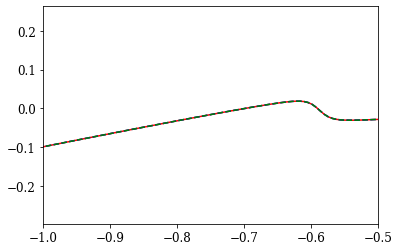

In [60]:
from scipy import interpolate
from scipy.interpolate import InterpolatedUnivariateSpline

### form spline for ground-state surface
Eg_spline = InterpolatedUnivariateSpline(cpes[:,0], np.real(cpes[:,2]), k=3)
Fg_spline = Eg_spline.derivative()

force = Fg_spline(one[:,0])


plt.plot(one[:,0], one[:,1], 'red')
plt.plot(two[:,0], two[:,1], 'b--')
plt.plot(one[:,0], force, 'g--')
plt.xlim(-1,-0.5)
plt.show()
